<a href="https://colab.research.google.com/github/yasstake/rusty-bot/blob/main/experimental/richmanbtc_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

richmanbtcさんの[mlbotの初心者向けチュートリアル](https://github.com/richmanbtc/mlbot_tutorial/blob/master/work/tutorial.ipynb)
をベースにRusyBot用に修正

## 考え方(yasstake)
mlbotのチュートリアルは、以下のことをおこなっているようだ。

### オリジナルの流れ（yasstakeの理解）
1. 学習
   1. ４本足を取引所から収集
   2. ４本足から特徴量を作成
   3. ４本足からATR/2だけ上下に指値を出した時、約定するかどうかを判定
   4. ATR/2で上下に指値をだした場合の利益率を売り・買いそれぞれでbuy_y, sell_yとして計算
   5. Lightgbm２つのモデルを作り特徴量から利益率を学習

2. バックテスト
   1. 特徴量から２つのモデルで予測した売りの利益率、買いの利益率を比較し利益率の高い方へ指値を出す。
   2. 指値で約定したかどうかを判定しバックテストを実施。


### 今回の実装

学習フェーズはBinanceMarketからohlcvを取得し、オリジナルの通りの特徴量を作成。Feeは固定で設定。

Lightgbmの学習は、とりあえず全部学習（＝つまり学習したデータと同じものであとでバックテストするのであんまり良くない）

バックテスト部分は、RustyBot用に全面書き換え。逐次Tickで約定判定。
（勇者はそのまま、dry_run, real_runへと進める）


In [1]:
! pip install rbot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 40.8 MB/s eta 0:00:00


In [2]:
! pip install joblib
! pip install lightgbm
! pip install matplotlib
# ! pip install numba   Python3.12では動かないので使わない。
! pip install numpy
! pip install pandas
! pip install scipy
! pip install scikit-learn
! pip install seaborn

In [4]:
# ta-libは、talib本体（C言語）とPythonラッパーのインストールが必要です。
# 本体のバイナリはLinux（Colab)の場合は、下記のようにしてインストールします。
# Mac/Windowsの場合は公式サイトをみて独自インストールをしてください。https://ta-lib.org/install/
# Linux Colab Only
import sys

if 'google.colab' in sys.modules:
    url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
    !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
    url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
    !curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4441    0  4441    0     0   9201      0 --:--:-- --:--:-- --:--:--  9194
100  517k  100  517k    0     0   425k      0  0:00:01  0:00:01 --:--:-- 3749k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4473    0  4473    0     0  12291      0 --:--:-- --:--:-- --:--:-- 12322
100  392k  100  392k    0     0   473k      0 --:--:-- --:--:-- --:--:-- 3192k


In [5]:
import math

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
# import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [6]:
# 4本足(ohlcv)から特徴量を計算する関数です。
# 4本足のデータフレームを受け取り、特徴量を計算して返します。

def calc_features(df):
    open = df['open']
    high = df['high']
    low = df['low']
    close = df['close']
    volume = df['volume']

    orig_columns = df.columns

    hilo = (high - low) / 2
    # 価格(hilo または close)を引いた後、価格(close)で割ることで標準化
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] = (df['BBANDS_upperband'] - hilo) / close
    df['BBANDS_middleband'] = (df['BBANDS_middleband'] - hilo) / close
    df['BBANDS_lowerband'] = (df['BBANDS_lowerband'] - hilo) / close
    df['DEMA'] = (talib.DEMA(close, timeperiod=30) - hilo) / close
    df['EMA'] = (talib.EMA(close, timeperiod=30) - hilo) / close
    df['HT_TRENDLINE'] = (talib.HT_TRENDLINE(close) - hilo) / close
    df['KAMA'] = (talib.KAMA(close, timeperiod=30) - hilo) / close
    df['MA'] = (talib.MA(close, timeperiod=30, matype=0) - hilo) / close
    df['MIDPOINT'] = (talib.MIDPOINT(close, timeperiod=14) - hilo) / close
    df['SMA'] = (talib.SMA(close, timeperiod=30) - hilo) / close
    df['T3'] = (talib.T3(close, timeperiod=5, vfactor=0) - hilo) / close
    df['TEMA'] = (talib.TEMA(close, timeperiod=30) - hilo) / close
    df['TRIMA'] = (talib.TRIMA(close, timeperiod=30) - hilo) / close
    df['WMA'] = (talib.WMA(close, timeperiod=30) - hilo) / close
    df['LINEARREG'] = (talib.LINEARREG(close, timeperiod=14) - close) / close
    df['LINEARREG_INTERCEPT'] = (talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close) / close


    # 価格(close)で割ることで標準化
    df['AD'] = talib.AD(high, low, close, volume) / close
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10) / close
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0) / close
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_PHASOR_inphase'] /= close
    df['HT_PHASOR_quadrature'] /= close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14) / close
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD_macd'] /= close
    df['MACD_macdsignal'] /= close
    df['MACD_macdhist'] /= close
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14) / close
    df['MOM'] = talib.MOM(close, timeperiod=10) / close
    df['OBV'] = talib.OBV(close, volume) / close
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14) / close
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1) / close
    df['TRANGE'] = talib.TRANGE(high, low, close) / close


    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)

    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    return df


In [7]:
# calc_featuresで作った特徴量から、利用する特徴量をリストにします。
# あとで df[features] とすることで、特徴量を抽出できます。

features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

print(features)

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA']


In [9]:
# RBOTのインストール
# DBの場所はColabの場合はGoolgeDriveにしてあります。
# ローカルの場合は空きがあるばしょを指定してください。（指定しないとMacだと Library/Application Support/以下のディレクトリになります。）

from rbot import BinanceConfig
from rbot import BinanceMarket

config = BinanceConfig.BTCUSDT

import sys

if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

  # DBの保存先をGoogle Driveに変更する
  config = BinanceConfig.BTCUSDT
  config.db_base_dir = '/content/drive/MyDrive'

# 超巨大DBができあがるので空いているでディスクを指定してください。
#config.db_base_dir = './'

market = BinanceMarket(config)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# 50日分一気にダウンロードすると結構時間がかかります。50日で６GBほどのDBができあがります。
# Colabではエラーになるかもしれません。その場合は、日数を減らすか少しづつ日数を増やしていってください（差分でダウンロードされます）
market.download(ndays=50, verbose=True, archive_only=True)

0

In [11]:
# 4本足データを作成します。（これまた案外時間のかかる処理です）
ohlcv = market.ohlcv(0, 0, 60*15)
ohlcv

timestamp,open,high,low,close,volume,count
datetime[μs],f64,f64,f64,f64,f64,u32
2023-11-01 00:00:00,34639.78,34668.05,34571.45,34587.68,552.6407,19807
2023-11-01 00:15:00,34587.68,34639.93,34502.71,34545.82,399.87114,16243
2023-11-01 00:30:00,34545.83,34599.14,34508.41,34508.41,317.59153,13083
2023-11-01 00:45:00,34508.41,34554.0,34500.15,34507.68,244.88071,9002
2023-11-01 01:00:00,34507.68,34527.59,34465.62,34520.06,253.58503,10068
2023-11-01 01:15:00,34520.06,34551.43,34494.78,34551.42,172.51548,7617
2023-11-01 01:30:00,34551.43,34557.11,34482.31,34502.4,225.31139,6889
2023-11-01 01:45:00,34502.4,34518.53,34475.68,34492.07,162.32564,5790
2023-11-01 02:00:00,34492.08,34492.08,34426.09,34485.36,233.79083,9002


In [12]:
# talibが使えるように、polarsのデータフレームをpandasのデータフレームに変換します。
ohlc_df = ohlcv.to_pandas()

In [13]:
# 4本足データから特徴量を計算します。
df = calc_features(ohlc_df)

In [14]:
# Binanceの手数料を設定します。一律0.01%としています。
df['fee'] = 0.01 * 0.01

## yの計算

yasstake コメント

yの計算のキモは以下の部分。FEPがちょっと正確に理解していないけれど、現在価格±ATRの指値での約定想定価格とすると、
y_buyは、以下を計算している。
* 約定した場合は、 (売った想定価格／買った価格) - 1 * 往復の手数料
* 約定しなかった場合は
```
# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
```
つまり利益率を計算している（０が±０）らしい。


約定確率を可視化。時期によって約定確率が大きく変わると良くない。


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32004 (\N{CJK UNIFIED IDEOGRAPH-7D04}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/li

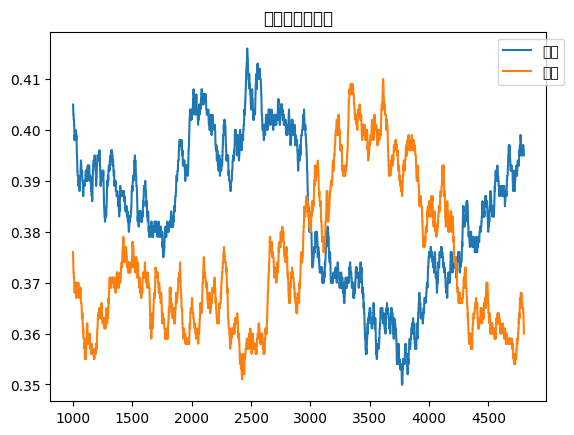

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12464 (\N{KATAKANA LETTER GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

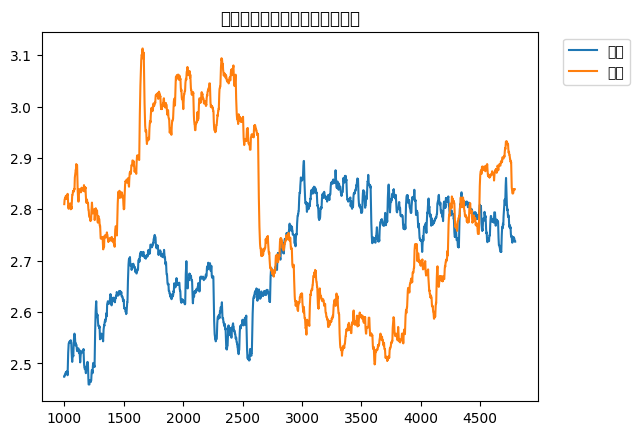

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


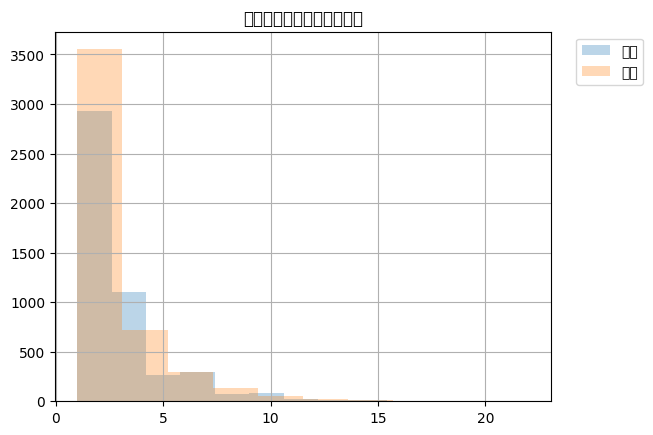

毎時刻、この執行方法でトレードした場合の累積リターン


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loca

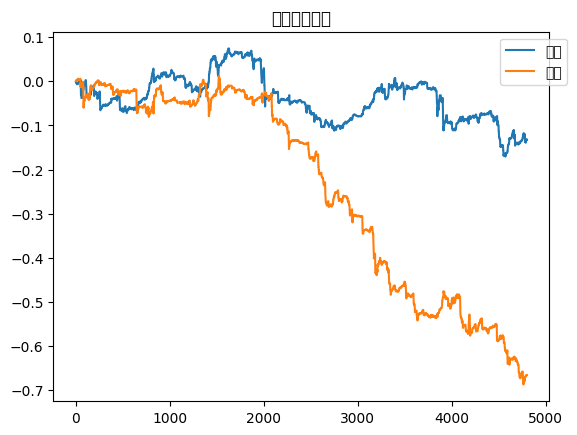

In [15]:
#@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['close'] - limit_price_dist
df['sell_price'] = df['close'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['low'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['high'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['low'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['high'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['close'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['close'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='買い')
df['sell_executed'].rolling(1000).mean().plot(label='売り')
plt.title('約定確率の推移')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='買い')
df['sell_fet'].rolling(1000).mean().plot(label='売り')
plt.title('エグジットまでの平均時間推移')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='買い')
df['sell_fet'].hist(alpha=0.3, label='売り')
plt.title('エグジットまでの時間分布')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_y.pkl')

In [16]:
df[['buy_fep', 'sell_fep', 'buy_executed', 'sell_executed', 'buy_price', 'sell_price']]

,buy_fep,sell_fep,buy_executed,sell_executed,buy_price,sell_price
0,34586.68,34588.68,1.0,1.0,34586.68,34588.68
1,34544.82,34546.82,1.0,1.0,34544.82,34546.82
2,34507.41,34509.41,1.0,1.0,34507.41,34509.41
3,34506.68,34508.68,1.0,1.0,34506.68,34508.68
4,34519.06,34521.06,1.0,1.0,34519.06,34521.06
...,...,...,...,...,...,...
4795,43508.64,NaN,1.0,0.0,43508.64,43714.64
4796,NaN,NaN,0.0,0.0,43413.17,43615.17
4797,NaN,NaN,0.0,0.0,43495.69,43693.69
4798,NaN,NaN,0.0,0.0,43550.00,43738.00


## モデルの学習

## ここからRustyBotの書き方(yasstake)

というよりも理解できなかったあたりを独自解釈で修正。

Yは約定したときの想定利益率を計算しているようだ。
そして、y_buyとy_sellを別にモデルで学習させている。

In [17]:
# 買いのときのY（利益率）予測するモデルを学習
buy_model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

buy_model.fit(df[features], df['y_buy'])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10009
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 43
[LightGBM] [Info] Start training from score -0.000028


LGBMRegressor(n_jobs=-1, random_state=1)

In [18]:
# 売りのときのY（利益率）予測するモデルを学習
sell_model =  lgb.LGBMRegressor(n_jobs=-1, random_state=1)

sell_model.fit(df[features], df['y_sell'])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10009
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 43
[LightGBM] [Info] Start training from score -0.000139


LGBMRegressor(n_jobs=-1, random_state=1)

## Agentの定義

1. `on_init`の中で１５分刻みで`on_clock`を呼び出すようにする。
2. on_clockでは、学習に使ったのと同じ幅の１５分足で１日分のohlcvを取得。
3. calc_featuresでohlcvから特徴量を計算
4. 売り、買いの２つのモデルでpredictして想定利益率を予測。
5. 売りと買いを比べて有利なほうで、現在価格からATRの半分離れた距離に指し値を出す

In [19]:
class MLBot:
  def __init__(self, sell_model, buy_model):
    self.sell_model = sell_model
    self.buy_model = buy_model

    self.ORDER_SIZE = 0.01
    self.POSITION_LIMIT = 0.09

    self.EXPIRE=60*60*3   # 3h


  def on_init(self, session):
    session.clock_interval_sec = 60 * 15   # 15分刻み

  def on_clock(self, session, clock):
    if session.expire_order(self.EXPIRE):
      return

    ohlcv = session.ohlcv(60*15, 4*24).to_pandas()      # 1日分の４本足を作成（15分x４＊２４本）
    f = calc_features(ohlcv)                            #学習時と同じ特徴量を作成

    x = f[features].tail(1) # 予測には最新の１本のみ採用
    sell_indicator = self.sell_model.predict(x)
    session.log_indicator("sell_indicator", sell_indicator)

    buy_indicator = self.buy_model.predict(x)
    session.log_indicator("buy_indicator", buy_indicator)

    # ATRで指値距離を計算します
    limit_price_dist = f['ATR'].tail(1)

    limit_price_dist = limit_price_dist.iloc[0] * 0.5
    close_price = f['close'].tail(1)

    close_price = close_price.iloc[0]

    session.log_indicator('ATR', f['ATR'].tail(1).iloc[0])

    if buy_indicator < sell_indicator:
      if session.buy_orders:
        return

      buy_price = close_price - limit_price_dist

      if session.position < self.POSITION_LIMIT:
        if math.isnan(buy_price):
          return

        #print("Buy", buy_price, self.ORDER_SIZE, "/", limit_price_dist, close_price)
        session.limit_order("Buy", buy_price, self.ORDER_SIZE)

    elif sell_indicator < buy_indicator:
      if session.sell_orders:
        return

      sell_price = close_price + limit_price_dist
      #print("SELL", sell_price)

      if -self.POSITION_LIMIT < session.position:
        if math.isnan(sell_price):
          return
        #print("Sell", sell_price, self.ORDER_SIZE,  "/", limit_price_dist, close_price)
        session.limit_order("Sell", sell_price, self.ORDER_SIZE)




agent = MLBot(sell_model, buy_model)



In [20]:
from rbot import Runner
from rbot import NOW, DAYS

runner = Runner()

# とりあえず５日分バックテスト
session = runner.back_test(market=market, agent=agent, verbose=True, start_time=NOW()-DAYS(5), end_time=0)

# すごく時間がかかりますが、全データ版はこちら
#session = runner.back_test(market=market, agent=agent, verbose=True, start_time=0, end_time=0)

In [21]:
log = session.log
orders = log.orders
orders

log_id,symbol,update_time,create_time,status,order_id,client_order_id,order_side,order_type,order_price,order_size,remain_size,transaction_id,execute_price,execute_size,quote_vol,commission,commission_asset,is_maker,message,commission_home,commission_foreign,home_change,foreign_change,free_home_change,free_foreign_change,lock_home_change,lock_foreign_change,open_position,close_position,position,profit,fee,total_profit,sum_profit
i64,str,datetime[μs],datetime[μs],str,str,str,str,str,f64,f64,f64,str,f64,f64,f64,f64,str,bool,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""BTCUSDT""",2023-12-17 01:29:27.592,2023-12-17 01:29:27.592,"""New""","""20231222T0129-…","""20231222T0129-…","""Buy""","""Limit""",42144.87,0.01,0.01,"""""",0.0,0.0,0.0,0.0,"""""",true,"""""",0.0,0.0,0.0,0.0,-421.4487,0.0,421.4487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"""BTCUSDT""",2023-12-17 01:37:11.388,2023-12-17 01:29:27.592,"""PartiallyFille…","""20231222T0129-…","""20231222T0129-…","""Buy""","""Limit""",42144.87,0.01,0.00894,"""20231222T0129-…",42144.87,0.00106,44.673562,0.0,"""""",true,"""""",0.0,0.0,-44.673562,0.00106,0.0,0.00106,-44.673562,0.0,0.00106,0.0,0.00106,0.0,0.004467,-0.004467,-0.004467
3,"""BTCUSDT""",2023-12-17 01:37:11.477,2023-12-17 01:29:27.592,"""PartiallyFille…","""20231222T0129-…","""20231222T0129-…","""Buy""","""Limit""",42144.87,0.01,0.00794,"""20231222T0129-…",42144.87,0.001,42.14487,0.0,"""""",true,"""""",0.0,0.0,-42.14487,0.001,0.0,0.001,-42.14487,0.0,0.001,0.0,0.00206,0.0,0.004214,-0.004214,-0.008682
4,"""BTCUSDT""",2023-12-17 01:37:12.092,2023-12-17 01:29:27.592,"""Filled""","""20231222T0129-…","""20231222T0129-…","""Buy""","""Limit""",42144.87,0.01,0.0,"""20231222T0129-…",42144.87,0.00794,334.630268,0.0,"""""",true,"""""",0.0,0.0,-334.630268,0.00794,0.0,0.00794,-334.630268,0.0,0.00794,0.0,0.01,0.0,0.033463,-0.033463,-0.042145
5,"""BTCUSDT""",2023-12-17 01:45:00,2023-12-17 01:45:00,"""New""","""20231222T0129-…","""20231222T0129-…","""Sell""","""Limit""",42120.62,0.01,0.01,"""""",0.0,0.0,0.0,0.0,"""""",true,"""""",0.0,0.0,0.0,0.0,0.0,-0.01,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.0,-0.042145
6,"""BTCUSDT""",2023-12-17 02:11:33.783,2023-12-17 01:45:00,"""Filled""","""20231222T0129-…","""20231222T0129-…","""Sell""","""Limit""",42120.62,0.01,0.0,"""20231222T0129-…",42120.62,0.01,421.2062,0.0,"""""",true,"""""",0.0,0.0,421.2062,-0.01,421.2062,-0.01,0.0,-0.01,0.0,0.01,0.0,-0.2425,0.042121,-0.284621,-0.326765
7,"""BTCUSDT""",2023-12-17 02:15:00.001,2023-12-17 02:15:00,"""New""","""20231222T0129-…","""20231222T0129-…","""Buy""","""Limit""",42053.39,0.01,0.01,"""""",0.0,0.0,0.0,0.0,"""""",true,"""""",0.0,0.0,0.0,0.0,-420.5339,0.0,420.5339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.326765
8,"""BTCUSDT""",2023-12-17 02:25:48.185,2023-12-17 02:15:00,"""PartiallyFille…","""20231222T0129-…","""20231222T0129-…","""Buy""","""Limit""",42053.39,0.01,0.00964,"""20231222T0129-…",42053.39,0.00036,15.13922,0.0,"""""",true,"""""",0.0,0.0,-15.13922,0.00036,0.0,0.00036,-15.13922,0.0,0.00036,0.0,0.00036,0.0,0.001514,-0.001514,-0.328279
9,"""BTCUSDT""",2023-12-17 02:25:48.259,2023-12-17 02:15:00,"""PartiallyFille…","""20231222T0129-…","""20231222T0129-…","""Buy""","""Limit""",42053.39,0.01,0.0028,"""20231222T0129-…",42053.39,0.00684,287.645188,0.0,"""""",true,"""""",0.0,0.0,-287.645188,0.00684,0.0,0.00684,-287.645188,0.0,0.00684,0.0,0.0072,0.0,0.028765,-0.028765,-0.357044


In [22]:
# 最終想定損益
orders['sum_profit'][-1]

-0.3481077699999465

In [23]:
# 手数料なし想定損益
orders['profit'].sum()

4.978300000000006

In [24]:
ohlcv = market.ohlcv(runner.start_timestamp, runner.last_timestamp, 60*15)

In [25]:
# バックテスト結果の可視化

# 数千件のデータを可視化するときは、plotlyを使うと便利。
# https://plotly.com/python/
# ただし約定データが万を超えると、ブラウザが重くなるので注意。一部データ切り取りなどが必要。

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.1, row_heights=[0.1, 0.1, 0.1, 0.6],
                    subplot_titles=("sell/buy indicator", "psudo-position", "psudo-profit", "candlestick"))

# row 1 (indicator)
sell_indicator = log['sell_indicator']
fig.add_trace(go.Scatter(x=sell_indicator['timestamp'], y=sell_indicator['sell_indicator'], name="sell_indicator"), row=1, col=1)

buy_indicator = log['buy_indicator']
fig.add_trace(go.Scatter(x=buy_indicator['timestamp'], y=buy_indicator['buy_indicator'], name="buy_indicator"), row=1, col=1)


# row 2 (position)
fig.add_trace(go.Scatter(x=orders['update_time'], y=orders['position'], name="position", line=dict(shape='hv')), row=2, col=1)

# row 3 (profit)
profit = orders['sum_profit']
fig.add_trace(go.Scatter(x=orders['update_time'], y=orders['sum_profit'], name="profit", line=dict(shape='hv')), row=3, col=1)

# row 4 (candlestick)
fig.add_candlestick(x=ohlcv['timestamp'], open=ohlcv['open'], high=ohlcv['high'], low=ohlcv['low'], close=ohlcv['close'], row=4, col=1)

# row 4 (order)
buy_orders = orders.filter((orders['order_side'] == 'Buy') & (orders['status'] == 'New'))
fig.add_trace(go.Scatter(x=buy_orders['update_time'], y=buy_orders['order_price'], mode='markers', marker=dict(symbol='arrow-up', color='red', size=10), name="buy"), row=4, col=1)

buy_orders = orders.filter((orders['order_side'] == 'Buy') & (orders['status'] == 'Filled'))
fig.add_trace(go.Scatter(x=buy_orders['update_time'], y=buy_orders['order_price'], mode='markers', marker=dict(symbol='cross-thin-open', color='red', size=10), name="buy filled"), row=4, col=1)

buy_orders = orders.filter((orders['order_side'] == 'Buy') & (orders['status'] == 'Canceled'))
fig.add_trace(go.Scatter(x=buy_orders['update_time'], y=buy_orders['order_price'], mode='markers', marker=dict(symbol='x-thin-open', color='red', size=10), name="buy canceled"), row=4, col=1)


sell_orders = orders.filter((orders['order_side'] == 'Sell') & (orders['status'] == 'New'))
fig.add_trace(go.Scatter(x=sell_orders['update_time'], y=sell_orders['order_price'], mode='markers', marker=dict(symbol='arrow-down', color='blue', size=10), name="sell"), row=4, col=1)

sell_orders = orders.filter((orders['order_side'] == 'Sell') & (orders['status'] == 'Filled'))
fig.add_trace(go.Scatter(x=sell_orders['update_time'], y=sell_orders['order_price'], mode='markers', marker=dict(symbol='cross-thin-open', color='blue', size=10), name="sell filled"), row=4, col=1)

sell_orders = orders.filter((orders['order_side'] == 'Sell') & (orders['status'] == 'Canceled'))
fig.add_trace(go.Scatter(x=sell_orders['update_time'], y=sell_orders['order_price'], mode='markers', marker=dict(symbol='x-thin-open', color='blue', size=10), name="sell canceled"), row=4, col=1)

fig.update_layout(height=800, title_text="MLBOT Backtest Result")

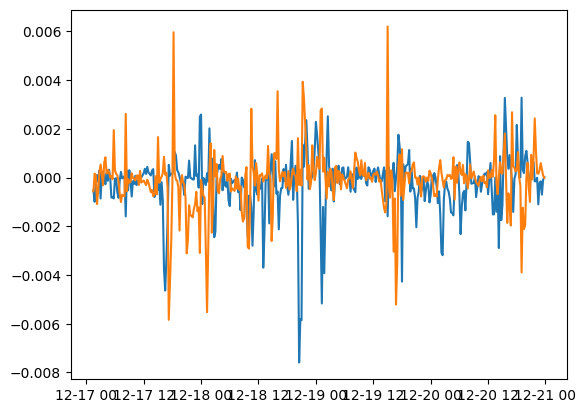

In [26]:
sell_i = log["sell_indicator"]
buy_i = log["buy_indicator"]

plt.plot(sell_i['timestamp'], sell_i['sell_indicator'])
plt.plot(buy_i['timestamp'], buy_i['buy_indicator'])